# Tutorial for the `crowdnalysis` library

*Last updated on Sep 15<sup>th</sup>, 2022*.

- GitHub: https://github.com/Crowd4SDG/crowdnalysis
- PyPI: https://pypi.org/project/crowdnalysis

## Table of Contents

- [Setup for Jupyter](#Setup-for-Jupyter)
- [Part 1: Data with a single question](#Part-1:-Data-with-a-single-question)
  - [Import data](#Import-data)
  - [Inter-rater reliability](#Inter-rater-reliability)
  - [Consensus and individual error-rates](#Consensus-and-individual-error-rates)
- [Part 2: Data with multiple questions](#Part-2:-Data-with-multiple-questions)
  - [Import extended data](#Import-extended-data)
  - [Set real classes for questions](#Set-real-classes-for-questions)
  - [Set dependency for a question](#Set-dependency-for-a-question)
  - [Inter-rater reliability for each question](#Inter-rater-reliability-for-each-question)
  - [Consensuses and individual error rates](#Consensuses-and-individual-error-rates)
- [Part 3: Error rates against ground truth](#Part-3:-Error-rates-against-ground-truth)
  - [Confusion matrix](#Confusion-matrix)
- [See also](#See-also)

## Setup for Jupyter
If you installed `crowdnalysis` in a virtual environment, make sure you've registered the environment to Jupyter.
To do that, activate your environment and run the following commmand. Note that the name of the kernel can be different than the environment name.
```bash
(myenv) $ python3 -m ipykernel install --user --name=myenv
```
And, select this kernel in the "Kernel > Change kernel" menu in Jupyter.

In [1]:
import crowdnalysis as cs
import pandas as pd
import numpy as np

In [2]:
cs.__version__

'1.1.2'

## Part 1: Data with a single question

Only one question is asked to the annotators. We calculate the following with the annotation data:

- Inter-rater reliability
- Consensus on annotations
- Error-rate matrices of annotators

### Import data

In [3]:
df1 = pd.read_json("tutorial1.json")
df1.tail()

,task_id,user_id,is_fast
15,Mazda,John,Yes
16,Mazda,Matthew,Yes
17,Kia,Matthew,Yes
18,Kia,Andrew,Yes
19,Kia,John,No


In [4]:
data1 = cs.data.Data.from_df(df1)

cars = data1.task_ids
questions = data1.questions
question = questions[0]
answers = data1.get_class_ids(question)  # i.e., classes
print("cars:", cars)
print("questions:", questions)
print("answers:", answers)
print("annotators:", data1.annotator_index_from_id)

cars: ['Audi' 'BMW' 'GM' 'Kia' 'Maserati' 'Mazda' 'Seat']
questions: ['is_fast']
answers: ['Yes', 'No']
annotators: {'Andrew': 0, 'John': 1, 'Matthew': 2}


### Inter-rater reliability

*Full agreement*: The ratio of tasks to which all annotators gave the same answer.

In [5]:
cs.agreement.full_agreement_percentage(data1, question)

0.7142857142857143

*Generalized Fleiss' Kappa*: [see](https://github.com/jmgirard/mReliability/wiki/Scott's-pi-coefficient)

In [6]:
cs.agreement.gen_fleiss_kappa(data1, question)

0.5333333333333333

### Consensus and individual error rates

Check available consensus models:

In [7]:
cs.factory.Factory.list_registered_algorithms()

['MajorityVoting',
 'Probabilistic',
 'DawidSkene',
 'StanMultinomialOptimize',
 'StanMultinomialEtaOptimize',
 'StanDSOptimize',
 'StanDSEtaHOptimize']

Use the Dawid-Skene model:

In [8]:
ds1 = cs.factory.Factory.make("DawidSkene")

Compute consensus and individual error rates:

In [9]:
consensus, params = ds1.fit_and_compute_consensus_from_data(data1, question)

In [10]:
print(f"Consensus for question '{question}':\n{consensus}")

Consensus for question 'is_fast':
[[0.92361645 0.07638355]
 [0.94655271 0.05344729]
 [0.27162537 0.72837463]
 [0.71691328 0.28308672]
 [0.84837212 0.15162788]
 [0.92361645 0.07638355]
 [0.09613437 0.90386563]]


Display consensus as a `pandas.DataFrame`:

In [11]:
cs.visualization.consensus_as_df(data1, question, consensus)

,Yes,No
Audi,0.923616,0.076384
BMW,0.946553,0.053447
GM,0.271625,0.728375
Kia,0.716913,0.283087
Maserati,0.848372,0.151628
Mazda,0.923616,0.076384
Seat,0.096134,0.903866


Print annotator error rates:

In [12]:
for ann, idx in data1.annotator_index_from_id.items():
    print(f"Error-rate matrix of {ann}:\n{params.pi[idx]}")

Error-rate matrix of Andrew:
[[0.8103665  0.1896335 ]
 [0.54881728 0.45118272]]
Error-rate matrix of John:
[[0.69009581 0.30990419]
 [0.31776    0.68224   ]]
Error-rate matrix of Matthew:
[[0.79959598 0.20040402]
 [0.36952158 0.63047842]]


Plot error-rate matrices:

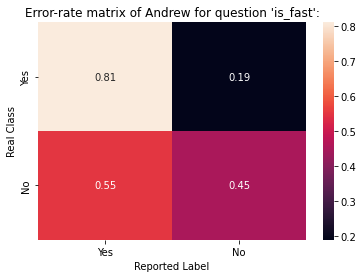

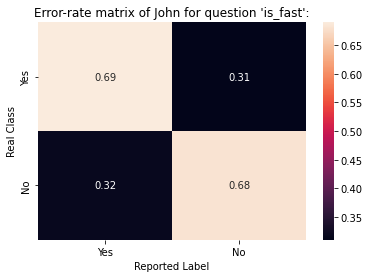

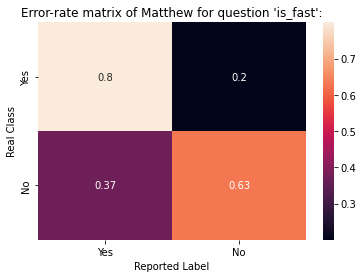

In [13]:
for ann, idx in data1.annotator_index_from_id.items():
    cs.visualization.plot_confusion(conf_mtx=params.pi[idx], classes=answers, labels=answers, fmt=".2g",
                                    title=f"Error-rate matrix of {ann} for question '{question}':", filename=None)

## Part 2: Data with multiple questions

In this example, annotators are asked to reply two consecutive questions for each task. We show how to

- Distingush real classes from reported labels,
- Set inter-dependencies between questions.

And, we compute the consensus and error-rates accordingly.

### Import extended data

In [14]:
df2 = pd.read_json("tutorial2.json")
df2.tail(12)

,task_id,user_id,is_car,is_fast
27,Cart,John,Not answered,Not answered
28,Cart,Matthew,Not answered,Not answered
29,Cart,Andrew,Not answered,Not answered
30,Cart,Samuel,Not answered,Not answered
31,Trolley,John,No,No
32,Trolley,Matthew,No,No
33,Trolley,Andrew,No,No
34,Trolley,Samuel,No,No
35,Flintmobile,John,No,No
36,Flintmobile,Matthew,Yes,No


### Set real classes for questions

Real classes for a question should be successive starting from index 0 within the answer categories (i.e. labels). A non-class label (e.g. 'Not answered') should come after the classes.

In [15]:
from pandas.api.types import CategoricalDtype
dtype = CategoricalDtype(categories=["Yes", "No", "Not answered"], ordered=False)
categories = {"is_car": dtype, "is_fast": dtype}
data2 = cs.data.Data.from_df(df2, categories=categories)
cars = data2.task_ids
print("cars:", cars.tolist())
questions = data2.questions
print("questions:", questions)
print("annotators:", data2.annotator_index_from_id)

cars: ['Audi', 'BMW', 'Cart', 'Flintmobile', 'GM', 'Kia', 'Maserati', 'Mazda', 'Seat', 'Trolley']
questions: ['is_car', 'is_fast']
annotators: {'Andrew': 0, 'John': 1, 'Matthew': 2, 'Samuel': 3}


Exclude 'Not answered' from the real classes:

In [16]:
for q in questions:
    print(f"Question '{q}':")
    labels = data2.get_categories()[q].categories
    print("\tLabels:", labels.tolist())
    classes = np.delete(labels, np.where(labels=="Not answered")).tolist()
    data2.set_classes(q, classes)
    print("\tClasses:", data2.get_class_ids(q))

Question 'is_car':
	Labels: ['Yes', 'No', 'Not answered']
	Classes: ['Yes', 'No']
Question 'is_fast':
	Labels: ['Yes', 'No', 'Not answered']
	Classes: ['Yes', 'No']


### Set dependency for a question

Set a dependency for the 'is_fast' question so that its answer is taken into account only when 'is_car=Yes':

`Data.set_condition(question, conditions)` function expects a valid string to be used in `pandas.DataFrame.query()` to set the dependency for the `question`. You can use the `Data.make_and_condition()` helper function as below to create conjunctive conditions. See the latter function's doc_string for options.

In [17]:
print("valid annotations for 'is_fast' before the condition:", len(data2.valid_rows("is_fast")))
cnd = cs.data.Data.make_and_condition([("is_car", "Yes")])
data2.set_condition("is_fast", cnd)
print("valid annotations for 'is_fast' after setting the condition:", len(data2.valid_rows("is_fast")))

valid annotations for 'is_fast' before the condition: 39
valid annotations for 'is_fast' after setting the condition: 27


### Inter-rater reliability for each question

In [18]:
for q in questions:
    print(f"Question '{q}':")
    print("\tFull agreement:", cs.agreement.full_agreement_percentage(data2, q))
    print("\tGeneralized Fleiss' kappa:", cs.agreement.gen_fleiss_kappa(data2, q))

Question 'is_car':
	Full agreement: 0.8
	Generalized Fleiss' kappa: 0.7132616487455201
Question 'is_fast':
	Full agreement: 0.3
	Generalized Fleiss' kappa: 0.272937103289094


### Consensuses and individual error rates

Compute consensus and individual error rates for *all* questions. Use Dawid-Skene:

In [19]:
ds2 = cs.factory.Factory.make("DawidSkene")
consensuses, parameters = ds2.fit_and_compute_consensuses_from_data(data2, questions)

Display the consensuses:

In [20]:
for q in questions:
    print(f"Consensus for question '{q}':")
    print(cs.visualization.consensus_as_df(data2, q, consensuses[q]), "\n")

Consensus for question 'is_car':
                  Yes        No
Audi         0.997436  0.002564
BMW          0.995452  0.004548
Cart         0.026863  0.973137
Flintmobile  0.110424  0.889576
GM           0.976581  0.023419
Kia          0.997436  0.002564
Maserati     0.993776  0.006224
Mazda        0.997436  0.002564
Seat         0.997436  0.002564
Trolley      0.010351  0.989649 

Consensus for question 'is_fast':
                  Yes        No
Audi         0.948533  0.051467
BMW          0.982519  0.017481
Flintmobile  0.330076  0.669924
GM           0.206933  0.793067
Kia          0.384259  0.615741
Maserati     0.935645  0.064355
Mazda        0.972118  0.027882
Seat         0.027088  0.972912 



>Note that Cart and Trolley are excluded from the 'is_fast' consensus.
This is because their annotations are ruled out by the dependency we set [above](#Set-dependency-for-a-question) for 'is_fast'. That is, all annotators agreed that they are not cars. On the other hand, Flintmobile remained in this consensus since Matthew believed it is actually a car.

Plot error-rate matrices:

Question 'is_car':


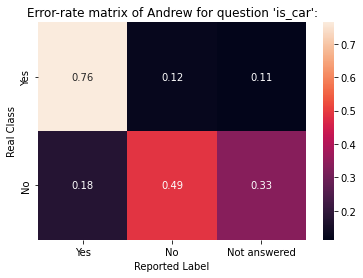

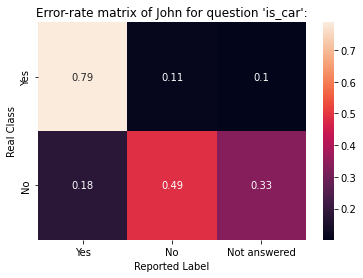

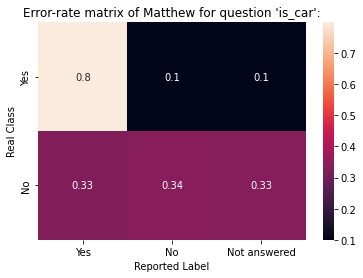

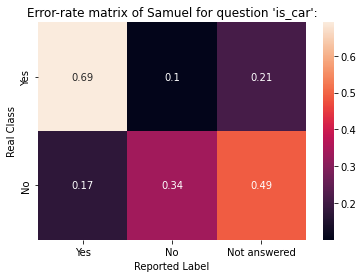

Question 'is_fast':


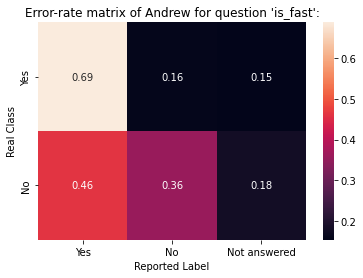

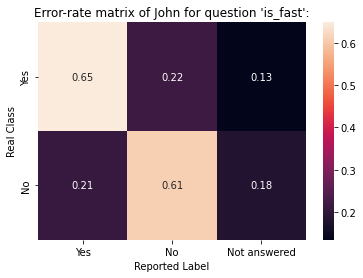

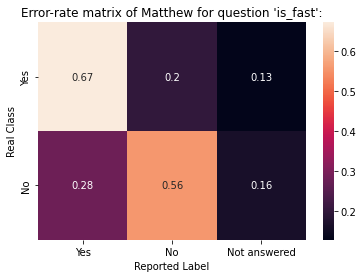

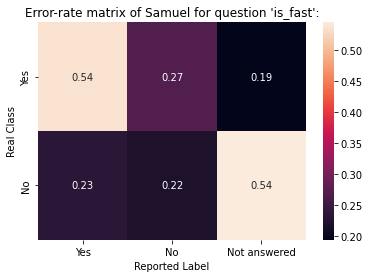

In [21]:
for q in questions:
    print(f"Question '{q}':")
    labels = data2.get_categories()[q].categories
    classes = np.delete(labels, np.where(labels=="Not answered")).tolist()
    for ann, idx in data2.annotator_index_from_id.items():
        cs.visualization.plot_confusion(conf_mtx=parameters[q].pi[idx], classes=classes, labels=labels, fmt=".2g",
                                        title=f"Error-rate matrix of {ann} for question '{q}':", filename=None)

## Part 3: Error rates against ground truth

We calculate the annotator error rates against a ground truth for the tasks. Let's say we have the following expert consensus available for the single question given in [Part 1](#Part-1:-Data-with-a-single-question):

In [22]:
from io import StringIO
expert_consensus = pd.read_csv(StringIO("""
task,        Yes,   No
Audi,        0.85,  0.15
BMW,         0.90,  0.10
GM,          0.40,  0.60
Kia,         0.20,  0.80
Maserati,    0.97,  0.03
Mazda,       0.77,  0.23
Seat,        0.35,  0.65
"""), index_col="task")
# expert_consensus

Calculate the error rates using Dawid-Skene model (*cf.* [Error rates](#Consensus-and-individual-error-rates) at Part 1 that were calculated without a ground truth).

In [23]:
ds3 = cs.factory.Factory.make("DawidSkene")
crowd_params = ds3.fit(data1.get_dcp(question="is_fast"), expert_consensus.to_numpy())

In [24]:
for ann, idx in data1.annotator_index_from_id.items():
    print(f"Error-rate matrix of {ann}:\n{crowd_params.pi[idx]}")

Error-rate matrix of Andrew:
[[0.75631769 0.24368231]
 [0.63004484 0.36995516]]
Error-rate matrix of John:
[[0.69720497 0.30279503]
 [0.33114035 0.66885965]]
Error-rate matrix of Matthew:
[[0.72527473 0.27472527]
 [0.51403888 0.48596112]]


### Confusion matrix

We generate the confusion matrix between the consensus on 'is_fast' that we calculated in [Part 1](#Consensus-and-individual-error-rates) and the expert consensus given [above](#Part-3:-Error-rates-against-ground-truth) that we use as the ground truth.

In [25]:
cs.analysis.gen_confusion_matrix(expert_consensus.to_numpy(), consensus, data1, "is_fast")

,Yes,No
Ground Truth,,
Yes,4,0
No,1,2


# See also

- `crowdnalysis.analysis` module to:
  - Compare the crowd data with experts' consensus
  - Carry out prospective analysis for hypothetical number of annotations
- `crowdnalysis.visualization` module to:
  - Generate HTML content for the consensus on a dataset of tasks with images
- `crowdnalysis.cmdstan` package to use Stan models